In [40]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)
#tf.logging.set_verbosity(tf.logging.ERROR)
print('Using TensorFlow version', tf.__version__)

2.19.0
Using TensorFlow version 2.19.0


In [41]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

fatal: destination path 'Person-Re-Id-Dataset' already exists and is not an empty directory.


In [42]:
import pandas as pd

df = pd.read_csv('/content/Person-Re-Id-Dataset/train.csv')
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [43]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

In [44]:
import tensorflow as tf

IMG_HEIGHT = 128
IMG_WIDTH = 64

def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255.0
    return img


In [45]:
import os

DATA_DIR = "Person-Re-Id-Dataset/train"

def load_triplet(row):
    anchor = load_image(os.path.join(DATA_DIR, row["Anchor"]))
    positive = load_image(os.path.join(DATA_DIR, row["Positive"]))
    negative = load_image(os.path.join(DATA_DIR, row["Negative"]))
    return anchor, positive, negative


In [46]:
def build_apn_arrays(df):
    anchors, positives, negatives = [], [], []

    for _, row in df.iterrows():
        a, p, n = load_triplet(row)
        anchors.append(a)
        positives.append(p)
        negatives.append(n)

    return (
        tf.stack(anchors),
        tf.stack(positives),
        tf.stack(negatives)
    )


In [47]:
train_A, train_P, train_N = build_apn_arrays(train_df)
val_A, val_P, val_N = build_apn_arrays(val_df)


In [48]:
print("Train Anchor shape :", train_A.shape)
print("Train Positive shape:", train_P.shape)
print("Train Negative shape:", train_N.shape)

print("Val Anchor shape   :", val_A.shape)
print("Val Positive shape :", val_P.shape)
print("Val Negative shape :", val_N.shape)


Train Anchor shape : (3200, 128, 64, 3)
Train Positive shape: (3200, 128, 64, 3)
Train Negative shape: (3200, 128, 64, 3)
Val Anchor shape   : (800, 128, 64, 3)
Val Positive shape : (800, 128, 64, 3)
Val Negative shape : (800, 128, 64, 3)


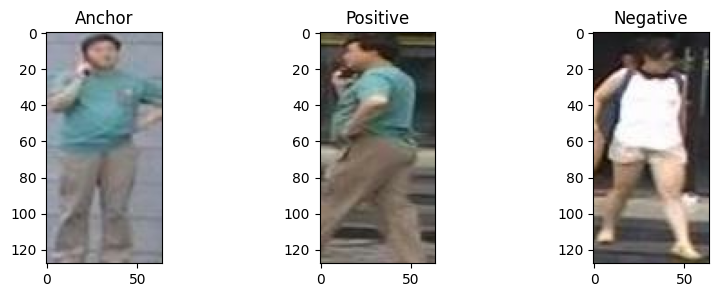

In [49]:
import matplotlib.pyplot as plt

idx = 5  # try a few values

plt.figure(figsize=(10,3))

plt.subplot(1,3,1)
plt.imshow(train_A[idx])
plt.title("Anchor")

plt.subplot(1,3,2)
plt.imshow(train_P[idx])
plt.title("Positive")

plt.subplot(1,3,3)
plt.imshow(train_N[idx])
plt.title("Negative")

plt.show()


In [50]:
def l2_normalize(x):
    return tf.math.l2_normalize(x, axis=1)


In [51]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

base = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(128, 64, 3)
)

x = GlobalAveragePooling2D()(base.output)
x = tf.keras.layers.Lambda(l2_normalize)(x)

embedding_model = Model(
    inputs=base.input,
    outputs=x
)


In [52]:
a = tf.expand_dims(train_A[0], axis=0)
emb = embedding_model(a)

print("Embedding shape:", emb.shape)
print("Embedding norm:", tf.norm(emb).numpy())


Embedding shape: (1, 1280)
Embedding norm: 1.0


In [53]:
val_embeddings = embedding_model.predict(val_A)
embeddings = embedding_model.predict(train_A)
print(embeddings.shape)


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
(3200, 1280)


In [54]:
print(f"Type: {type(train_A[0])}")
print(f"Value: {train_A[0]}")

Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Value: [[[0.5764706  0.5764706  0.5764706 ]
  [0.5764706  0.5764706  0.5764706 ]
  [0.5764706  0.5764706  0.5764706 ]
  ...
  [0.23921569 0.2509804  0.20784314]
  [0.24705882 0.25882354 0.21568628]
  [0.24705882 0.25882354 0.21568628]]

 [[0.5529412  0.5529412  0.5529412 ]
  [0.5568628  0.5568628  0.5568628 ]
  [0.5647059  0.5647059  0.5647059 ]
  ...
  [0.21176471 0.22352941 0.18039216]
  [0.21568628 0.22745098 0.18431373]
  [0.21960784 0.23137255 0.1882353 ]]

 [[0.5568628  0.5568628  0.5568628 ]
  [0.56078434 0.56078434 0.56078434]
  [0.56078434 0.56078434 0.56078434]
  ...
  [0.15294118 0.16470589 0.12156863]
  [0.16078432 0.17254902 0.12941177]
  [0.16470589 0.1764706  0.13333334]]

 ...

 [[0.5411765  0.5372549  0.5176471 ]
  [0.54509807 0.5411765  0.52156866]
  [0.54509807 0.5411765  0.52156866]
  ...
  [0.46666667 0.46666667 0.46666667]
  [0.60784316 0.60784316 0.60784316]
  [0.57254905 0.57254905 0.57254905]]

 [[0.56

In [55]:
img = train_A[0]                  # already an image
img = tf.expand_dims(img, axis=0) # add batch dim

embedding = embedding_model.predict(img)
print(embedding)



1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
[[-0.01437069 -0.0228408  -0.02023056 ... -0.02230243 -0.0098403
  -0.00743392]]


In [56]:
def triplet_loss(anchor, positive, negative, margin=0.5):
    d_ap = tf.norm(anchor - positive, axis=1)
    d_an = tf.norm(anchor - negative, axis=1)
    loss = tf.maximum(d_ap - d_an + margin, 0.0)
    return tf.reduce_mean(loss)


In [57]:
a = tf.expand_dims(train_A[0], axis=0)
p = tf.expand_dims(train_P[0], axis=0)
n = tf.expand_dims(train_N[0], axis=0)

emb_a = embedding_model(a)
emb_p = embedding_model(p)
emb_n = embedding_model(n)


In [58]:
print(emb_p)

tf.Tensor(
[[-0.01449122 -0.02286084 -0.02035202 ... -0.02243488 -0.00970948
  -0.00734844]], shape=(1, 1280), dtype=float32)


In [59]:
loss_val = triplet_loss(emb_a, emb_p, emb_n)
print("Triplet loss:", loss_val.numpy())

Triplet loss: 0.504173


In [60]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)


In [61]:
@tf.function
def train_step(anchor, positive, negative):
    with tf.GradientTape() as tape:
        emb_a = embedding_model(anchor, training=True)
        emb_p = embedding_model(positive, training=True)
        emb_n = embedding_model(negative, training=True)

        loss = triplet_loss(emb_a, emb_p, emb_n)

    grads = tape.gradient(loss, embedding_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, embedding_model.trainable_variables))

    return loss


In [62]:
EPOCHS = 10
BATCH_SIZE = 8

num_batches = len(train_A) // BATCH_SIZE

for epoch in range(EPOCHS):
    epoch_loss = 0.0

    for i in range(num_batches):
        a = train_A[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        p = train_P[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        n = train_N[i*BATCH_SIZE:(i+1)*BATCH_SIZE]

        loss = train_step(a, p, n)
        epoch_loss += loss.numpy()

    avg_loss = epoch_loss / num_batches
    print(f"Epoch {epoch+1}/{EPOCHS} - Triplet Loss: {avg_loss:.4f}")


Epoch 1/15 - Triplet Loss: 0.3198
Epoch 2/15 - Triplet Loss: 0.1145
Epoch 3/15 - Triplet Loss: 0.0539
Epoch 4/15 - Triplet Loss: 0.0279
Epoch 5/15 - Triplet Loss: 0.0137
Epoch 6/15 - Triplet Loss: 0.0099
Epoch 7/15 - Triplet Loss: 0.0057
Epoch 8/15 - Triplet Loss: 0.0046
Epoch 9/15 - Triplet Loss: 0.0029
Epoch 10/15 - Triplet Loss: 0.0035
Epoch 11/15 - Triplet Loss: 0.0023
Epoch 12/15 - Triplet Loss: 0.0035
Epoch 13/15 - Triplet Loss: 0.0022
Epoch 14/15 - Triplet Loss: 0.0028
Epoch 15/15 - Triplet Loss: 0.0023


In [63]:
embedding_model.save("embedding_model.keras")


In [71]:
import tensorflow as tf

def l2_normalize(x):
    return tf.math.l2_normalize(x, axis=1)

embedding_model = tf.keras.models.load_model(
    "embedding_model.keras",
    custom_objects={"l2_normalize": l2_normalize}
)


In [72]:
idx = 2  # try different values later

a = tf.expand_dims(val_A[idx], axis=0)
p = tf.expand_dims(val_P[idx], axis=0)
n = tf.expand_dims(val_N[idx], axis=0)


In [73]:
emb_a = embedding_model(a)
emb_p = embedding_model(p)
emb_n = embedding_model(n)


In [74]:
d_ap = tf.norm(emb_a - emb_p).numpy()
d_an = tf.norm(emb_a - emb_n).numpy()

print("Anchor–Positive distance:", d_ap)
print("Anchor–Negative distance:", d_an)


Anchor–Positive distance: 0.4797522
Anchor–Negative distance: 1.2795724


In [75]:
correct = 0
N = 100

for i in range(N):
    a = tf.expand_dims(val_A[i], axis=0)
    p = tf.expand_dims(val_P[i], axis=0)
    n = tf.expand_dims(val_N[i], axis=0)

    emb_a = embedding_model(a)
    emb_p = embedding_model(p)
    emb_n = embedding_model(n)

    if tf.norm(emb_a - emb_p) < tf.norm(emb_a - emb_n):
        correct += 1

print(f"Correct ordering: {correct}/{N}")


Correct ordering: 84/100
